# RANSAC-RANdom Sample Consensus
Author: Chul Min Yeum  
Email: cmyeum@uwaterloo.ca  

Last updated: 2023-10-13

## Table of Contents
* Linear Least Square
* Line Fitting using RANSAC 
* How to Decide the Distance Threshold (delta)
* How to Decide the Number of Trials (N) & Confidence (p)
* RANSAC Demo

## Linear Least Square: Simulation

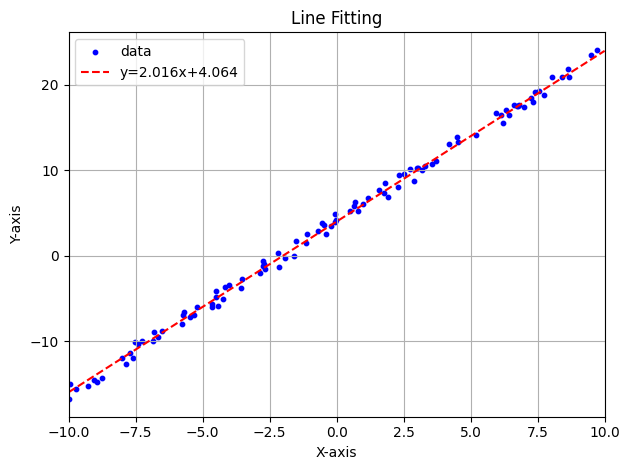

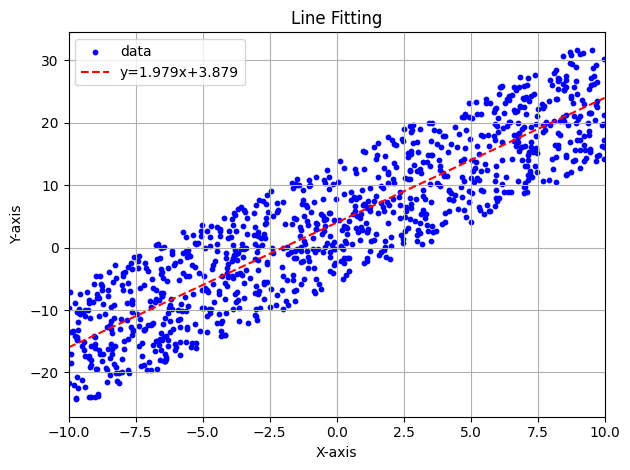

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Line fitting function
def line_fitting(num_pt, noise_level, m, b, xrange):
    x = np.random.rand(num_pt) * (xrange[1] - xrange[0]) + xrange[0]
    y_true = m * x + b
    y_meas = y_true + noise_level * (np.random.rand(num_pt) * 2 - 1)

    Xmat = np.column_stack([x, np.ones(num_pt)])
    fparam = np.linalg.pinv(Xmat).dot(y_meas)

    plt.scatter(x, y_meas, c='b', s=10)
    plt.plot(xrange, m * np.array(xrange) + b, 'r--', linewidth=1.5)
    plt.legend(['data', f'y={fparam[0]:.3f}x+{fparam[1]:.3f}'])
    plt.axis('tight')
    plt.grid(True)
    plt.title('Line Fitting')
    plt.xlabel('X-axis')
    plt.xlim(xrange)
    plt.ylabel('Y-axis')
    plt.tight_layout()
    plt.show()

# For 100 points with smaller noise
line_fitting(100, 1, 2, 4, [-10, 10])

# For 1000 points with larger noise
line_fitting(1000, 10, 2, 4, [-10, 10])


## Linear Least Square with Outlier

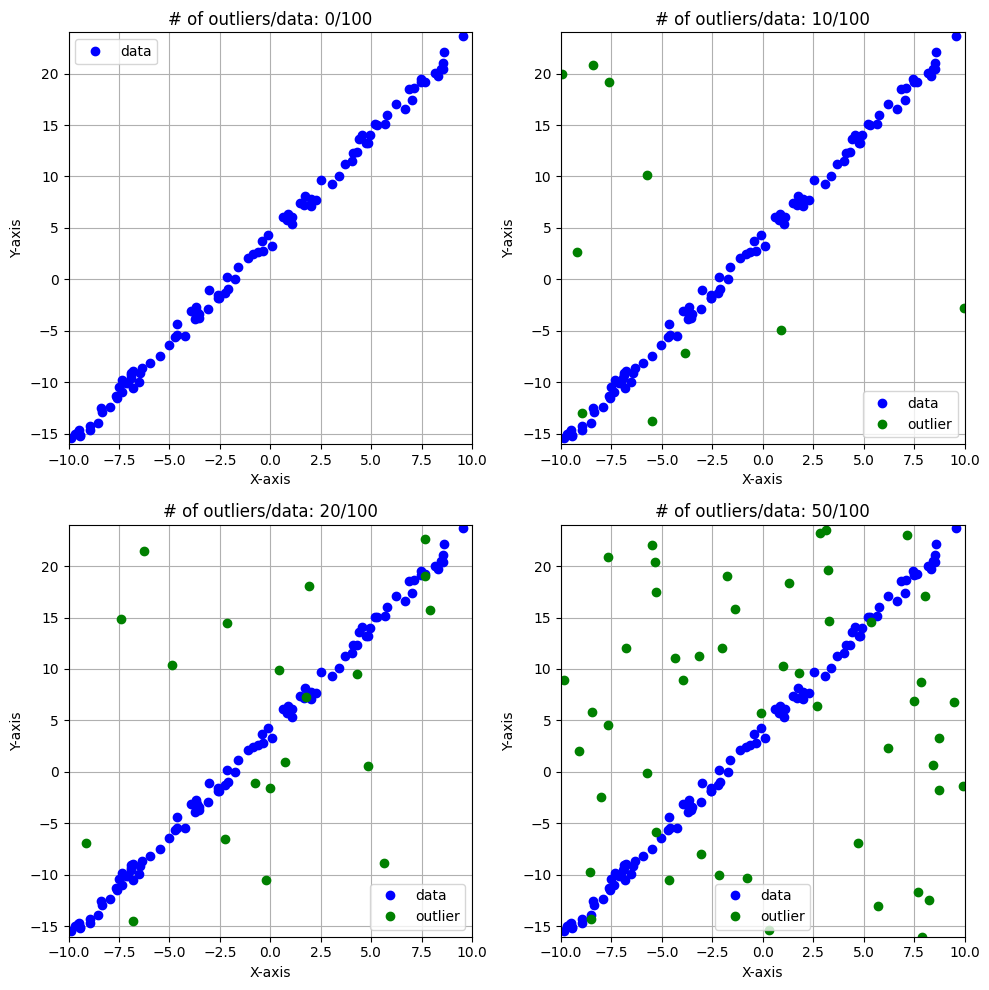

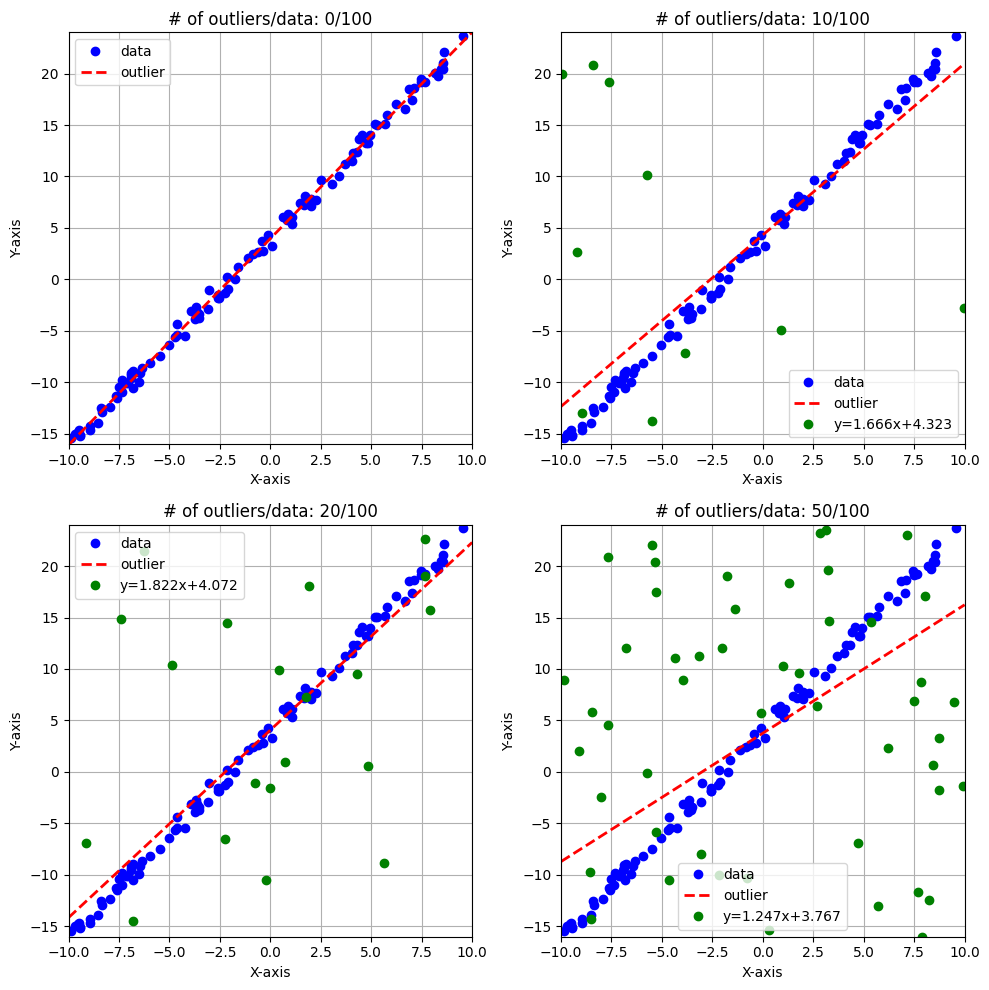

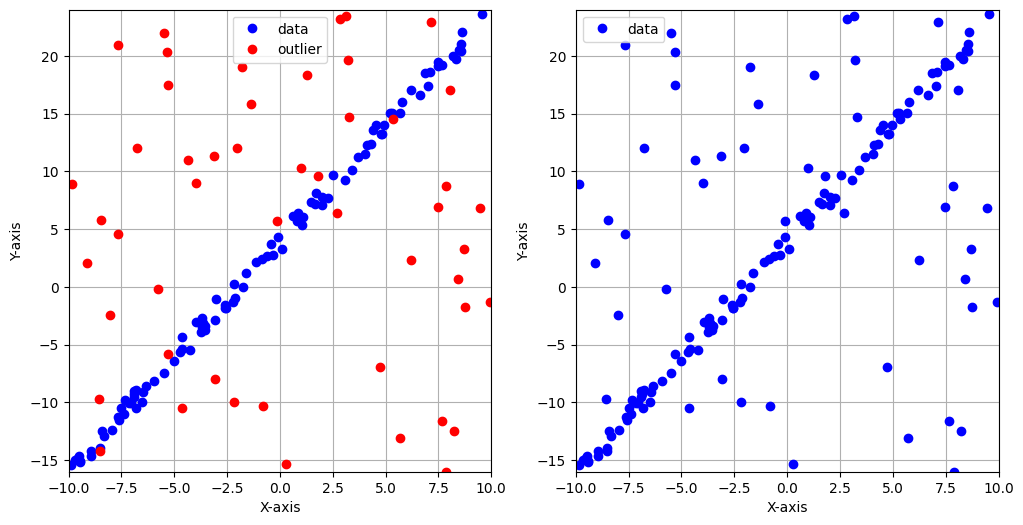

In [9]:
import numpy as np
import matplotlib.pyplot as plt

num_pt = 100
m = 2
b = 4
xrange = [-10, 10]
yrange = [m*el+b for el in xrange]

x = np.random.rand(num_pt) * (xrange[1] - xrange[0]) + xrange[0]
y_true = m * x + b
y_meas = y_true + (np.random.rand(num_pt) * 2 - 1)

Xmat = np.column_stack([x, np.ones(num_pt)])
fparam = np.linalg.pinv(Xmat) @ y_meas

out_ratio = [0, 0.1, 0.2, 0.5]
x_out = []
y_out = []
fparam_set = np.zeros((2, len(out_ratio)))

for ii, ratio in enumerate(out_ratio):
    x_out_temp = np.random.rand(int(num_pt * ratio)) * (xrange[1] - xrange[0]) + xrange[0]
    y_out_temp = np.random.rand(int(num_pt * ratio)) * (yrange[1] - yrange[0]) + yrange[0]

    x_out.append(x_out_temp)
    y_out.append(y_out_temp)

    Xmat_temp = np.column_stack([np.append(x, x_out_temp), np.ones(num_pt + len(x_out_temp))])
    Ymat_temp = np.append(y_meas, y_out_temp)
    fparam_set[:, ii] = np.linalg.pinv(Xmat_temp) @ Ymat_temp

plt.figure(2, figsize=(10, 10))

plots = [221, 222, 223, 224]
for i, plot_num in enumerate(plots):
    plt.subplot(plot_num)
    plt.plot(x, y_meas, 'ob', linewidth=1.5)
    if i > 0:
        plt.plot(x_out[i], y_out[i], 'og', linewidth=1.5)
    plt.legend(['data', 'outlier'])
    plt.axis('tight')
    plt.grid(True)
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.title(f'# of outliers/data: {int(num_pt*out_ratio[i])}/{num_pt}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

plt.tight_layout()
plt.show()

plt.figure(3, figsize=(10, 10))

for i, plot_num in enumerate(plots):
    plt.subplot(plot_num)
    plt.plot(x, y_meas, 'ob', linewidth=1.5)
    plt.plot(xrange, [fparam_set[0,i]*x_val + fparam_set[1,i] for x_val in xrange], 'r--', linewidth=2)
    if i > 0:
        plt.plot(x_out[i], y_out[i], 'og', linewidth=1.5)
    plt.legend(['data', 'outlier', f'y={fparam_set[0,i]:.3f}x+{fparam_set[1,i]:.3f}'])
    plt.axis('tight')
    plt.grid(True)
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.title(f'# of outliers/data: {int(num_pt*out_ratio[i])}/{num_pt}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

plt.tight_layout()
plt.show()

# Extra figures for slide preparation
plt.figure(4, figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(x, y_meas, 'ob', linewidth=1.5)
plt.plot(x_out[-1], y_out[-1], 'or', linewidth=1.5)
plt.legend(['data', 'outlier'])
plt.grid(True)
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.subplot(1,2,2)
plt.plot(np.append(x, x_out[-1]), np.append(y_meas, y_out[-1]), 'ob', linewidth=1.5)
plt.legend(['data'])
plt.grid(True)
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


## Line Fitting using RANSAC 

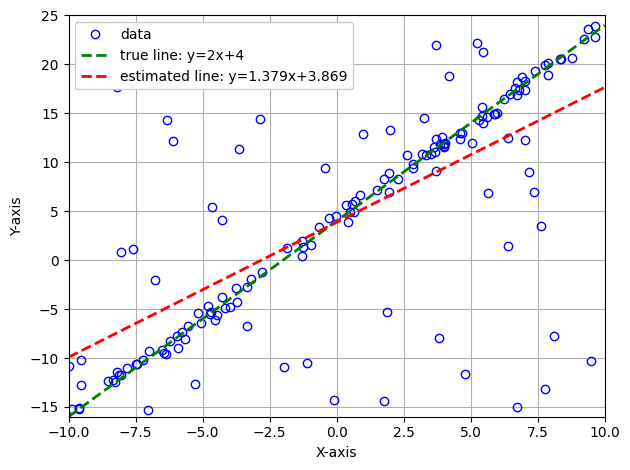

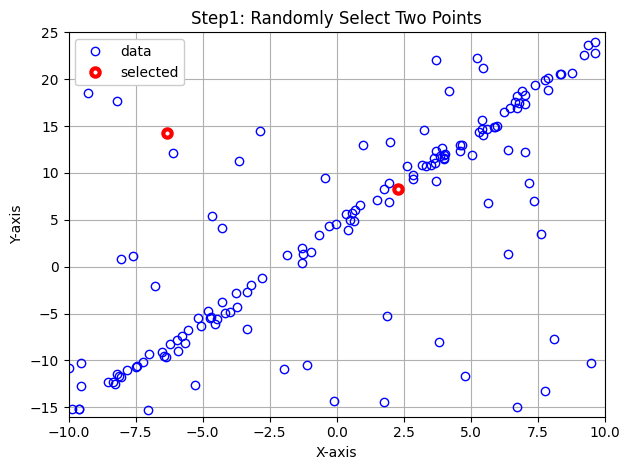

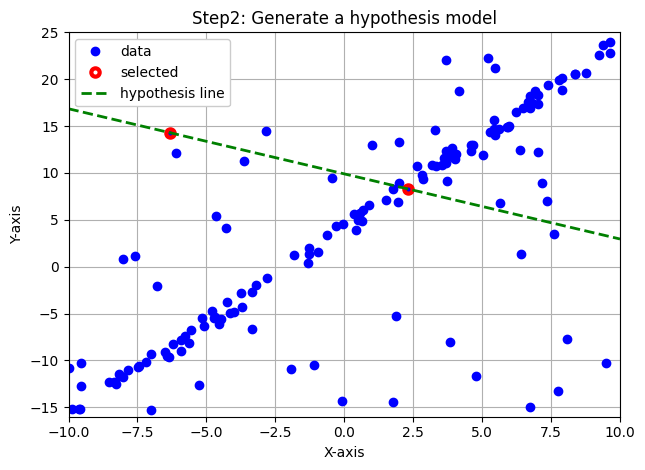

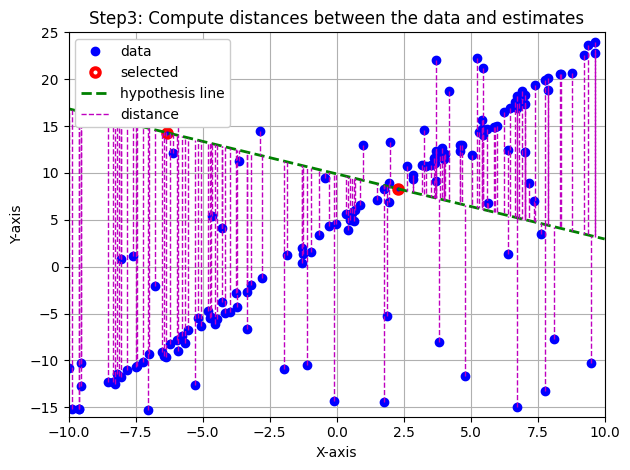

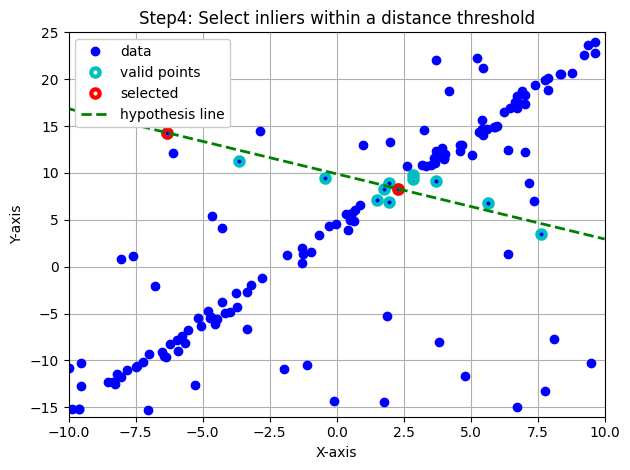

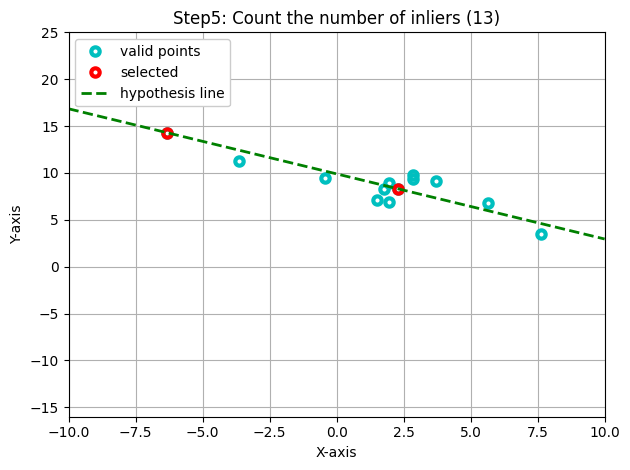

In [33]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(113)

num_pt = 100

# line equation y = mx + b
m = 2
b = 4

# x-axis range
xrange = [-10, 10]
x = np.random.rand(num_pt) * (xrange[1] - xrange[0]) + xrange[0]

y_true = m*x + b
x_meas = x
y_meas = y_true + (np.random.rand(num_pt)*2 - 1)

yrange = [m*xrange[0] + b, m*xrange[1] + b]
x_out = np.random.rand(num_pt//2) * (xrange[1] - xrange[0]) + xrange[0]
y_out = np.random.rand(num_pt//2) * (yrange[1] - yrange[0]) + yrange[0]

x_data = np.concatenate([x_meas, x_out])
y_data = np.concatenate([y_meas, y_out])

# Least squares fit
Xmat = np.column_stack([x_data, np.ones_like(x_data)])
fparam = np.linalg.pinv(Xmat) @ y_data

plt.figure()
plt.plot(x_data, y_data, 'ob', fillstyle='none', linewidth=1.5)
plt.plot(xrange, [m*val+b for val in xrange], 'g--', linewidth=2)
plt.plot(xrange, [fparam[0]*val+fparam[1] for val in xrange], 'r--', linewidth=2)
plt.legend(['data', f'true line: y={m}x+{b}', f'estimated line: y={fparam[0]:.3f}x+{fparam[1]:.3f}'], loc=2, fontsize=10, facecolor="white", framealpha=1)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(-10, 10), plt.ylim(-16, 25)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 1: Randomly Select Two Points
pt_idx = np.random.choice(len(x_data), 2, replace=False)
x_sub = x_data[pt_idx]
y_sub = y_data[pt_idx]

# Line equation from two points
mh = (y_sub[1] - y_sub[0]) / (x_sub[1] - x_sub[0])
bh = y_sub[0] - mh * x_sub[0]

plt.figure()
plt.plot(x_data, y_data, 'ob', fillstyle='none', linewidth=1.5)
plt.plot(x_sub, y_sub, 'or', fillstyle='none', markeredgewidth=3)
plt.title('Step1: Randomly Select Two Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.xlim(-10, 10), plt.ylim(-16, 25)
plt.tight_layout()
plt.legend(['data', 'selected'],loc=2, fontsize=10, facecolor="white", framealpha=1)
plt.show()

# Step 2: Generate a hypothesis model
plt.figure()
plt.plot(x_data, y_data, 'ob', linewidth=1.5)
plt.plot(x_sub, y_sub, 'or', fillstyle='none', markeredgewidth=3)
plt.plot(xrange, [mh*val+bh for val in xrange], 'g--', linewidth=2)
plt.title('Step2: Generate a hypothesis model')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.tight_layout()
plt.xlim(-10, 10), plt.ylim(-16, 25)
plt.legend(['data', 'selected', 'hypothesis line'],loc=2, fontsize=10, facecolor="white", framealpha=1)
plt.show()

# Step 3: Compute distances between the data and estimates
plt.figure()
plt.plot(x_data, y_data, 'ob', linewidth=1.5)
plt.plot(x_sub, y_sub, 'or', fillstyle='none', markeredgewidth=3)
plt.plot(xrange, [mh*val+bh for val in xrange], 'g--', linewidth=2)
for i, j, k in zip(x_data, y_data, mh*x_data + bh):
    plt.plot([i, i], [j, k], 'm--', linewidth=1)
plt.title('Step3: Compute distances between the data and estimates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.xlim(-10, 10), plt.ylim(-16, 25)
plt.tight_layout()
plt.legend(['data', 'selected', 'hypothesis line', 'distance'], loc=2, fontsize=10, facecolor="white", framealpha=1)
plt.show()

# Step 4: Select inliers within a distance threshold
dist_pt = mh*x_data + bh - y_data
dist_threshold = 2
valid_pt = np.abs(dist_pt) < dist_threshold

plt.figure()
plt.plot(x_data, y_data, 'ob', linewidth=1.5)
plt.plot(x_data[valid_pt], y_data[valid_pt], 'oc', fillstyle='none', markeredgewidth=3)
plt.plot(x_sub, y_sub, 'or', fillstyle='none', markeredgewidth=3)
plt.plot(xrange, [mh*val+bh for val in xrange], 'g--', linewidth=2)
plt.title('Step4: Select inliers within a distance threshold')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.xlim(-10, 10), plt.ylim(-16, 25)
plt.tight_layout()
plt.legend(['data', 'valid points', 'selected', 'hypothesis line'], loc=2, fontsize=10, facecolor="white", framealpha=1)
plt.show()

# Step 5: Count the number of inliers
plt.figure()
plt.plot(x_data[valid_pt], y_data[valid_pt], 'oc', fillstyle='none', markeredgewidth=3)
plt.plot(x_sub, y_sub, 'or', fillstyle='none', markeredgewidth=3)
plt.plot(xrange, [mh*val+bh for val in xrange], 'g--', linewidth=2)
plt.title(f'Step5: Count the number of inliers ({sum(valid_pt)})')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.xlim(-10, 10), plt.ylim(-16, 25)
plt.tight_layout()
plt.legend(['valid points', 'selected', 'hypothesis line'], loc=2, fontsize=10, facecolor="white", framealpha=1)
plt.show()



## How to Decide the Distance Threshold (delta)


C:\Users\cmyeum\AppData\Local\Temp\ipykernel_23924\3867980019.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot([xi, xi], [yi, float(mh * xi + bh)], 'm--', linewidth=1)


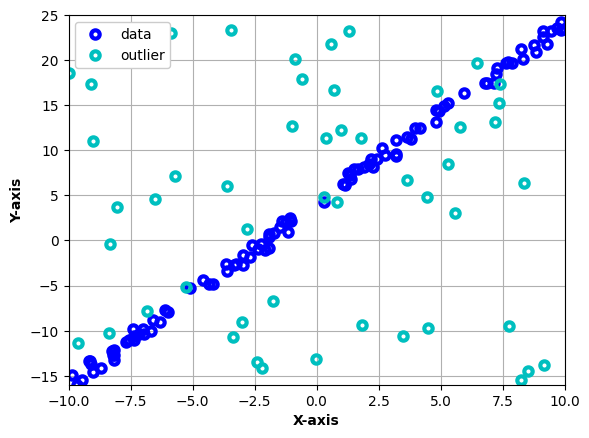

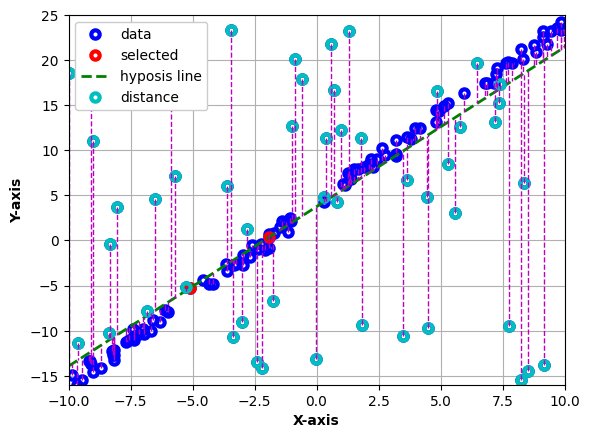

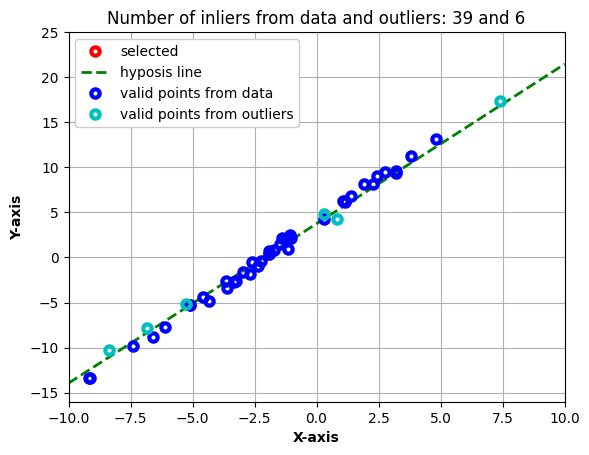

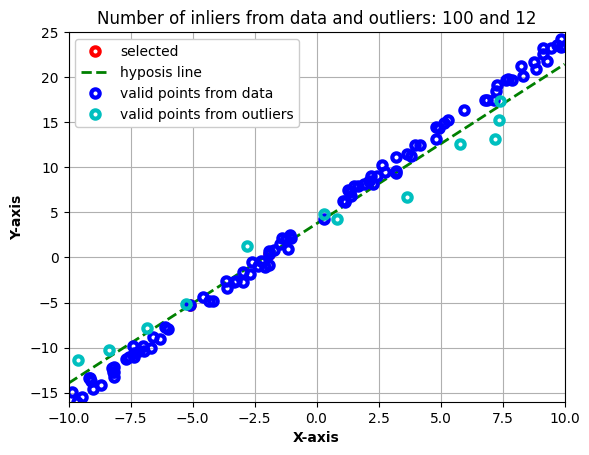

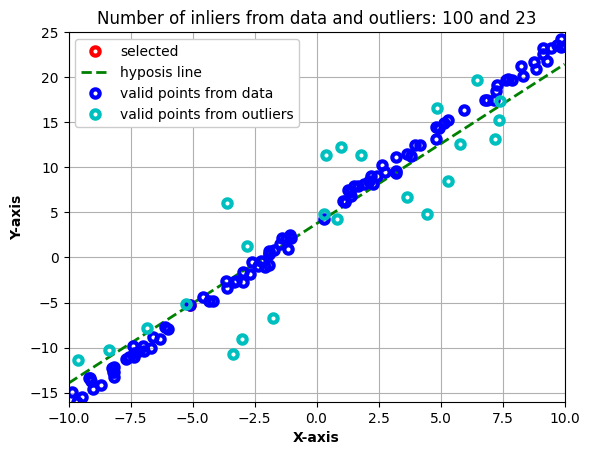

In [32]:
import numpy as np
import matplotlib.pyplot as plt

num_pt = 100

# Line equation y = mx + b
m = 2
b = 4

# x-axis range
xrange = [-10, 10]
x = np.random.rand(num_pt) * (xrange[1] - xrange[0]) + xrange[0]

y_true = m * x + b
x_meas = x
y_meas = y_true + (np.random.rand(num_pt) * 2 - 1)

yrange = [m * xrange[0] + b, m * xrange[1] + b]
x_out = np.random.rand(int(num_pt * 0.5)) * (xrange[1] - xrange[0]) + xrange[0]
y_out = np.random.rand(int(num_pt * 0.5)) * (yrange[1] - yrange[0]) + yrange[0]

x_combined = np.concatenate([x_meas, x_out])
ones_col = np.ones(num_pt + len(x_out))
Xmat = np.column_stack((x_combined, ones_col))

Ymat = np.concatenate((y_meas, y_out))
fparam = np.linalg.pinv(Xmat).dot(Ymat)

x_data = np.concatenate((x_meas, x_out))
y_data = np.concatenate((y_meas, y_out))

# Setting the seed for reproducibility
np.random.seed(17)
pt_idx = np.random.choice(num_pt + len(x_out), 2, replace=False)
x_sub = x_data[pt_idx]
y_sub = y_data[pt_idx]

mh = np.diff(y_sub) / np.diff(x_sub)
bh = np.linalg.det(np.column_stack((y_sub, x_sub))) / np.diff(x_sub)
dist_pt = mh * x_data + bh - y_data

plt.figure(11)
plt.plot(x_meas, y_meas, 'ob', fillstyle='none', markeredgewidth=3)
plt.plot(x_out, y_out, 'oc', fillstyle='none', markeredgewidth=3)
plt.legend(['data', 'outlier'], loc=2, fontsize=10, facecolor="white", framealpha=1)
plt.grid(True)
plt.xlabel('X-axis', fontweight='bold')
plt.ylabel('Y-axis', fontweight='bold')
plt.xlim(-10, 10), plt.ylim(-16, 25)

plt.figure(12)
plt.plot(x_data, y_data, 'ob', fillstyle='none', markeredgewidth=3)
plt.plot(x_sub, y_sub, 'or', fillstyle='none', markeredgewidth=3)
plt.plot(xrange, [mh * xr + bh for xr in xrange], 'g--', linewidth=2)
plt.plot(x_out, y_out, 'oc', fillstyle='none', markeredgewidth=3)
for xi, yi in zip(x_data, y_data):
    plt.plot([xi, xi], [yi, float(mh * xi + bh)], 'm--', linewidth=1)
plt.legend(['data', 'selected', 'hyposis line', 'distance'], loc=2, fontsize=10, facecolor="white", framealpha=1)
plt.grid(True)
plt.xlabel('X-axis', fontweight='bold')
plt.ylabel('Y-axis', fontweight='bold')
plt.xlim(-10, 10), plt.ylim(-16, 25)


def plot_threshold(threshold, fig_num):
    plt.figure(fig_num)
    valid_pt = np.abs(dist_pt) < threshold
    vald_pt_data = np.copy(valid_pt)
    vald_pt_data[num_pt:] = 0
    vald_pt_out = np.copy(valid_pt)
    vald_pt_out[:num_pt] = 0
    plt.plot(x_sub, y_sub, 'or', fillstyle='none', markeredgewidth=3)
    plt.plot(xrange, [mh * xr + bh for xr in xrange], 'g--', linewidth=2)
    plt.plot(x_data[vald_pt_data], y_data[vald_pt_data], 'ob', fillstyle='none', markeredgewidth=3)
    plt.plot(x_data[vald_pt_out], y_data[vald_pt_out], 'oc', fillstyle='none', markeredgewidth=3)
    plt.legend(['selected', 'hyposis line', 'valid points from data', 'valid points from outliers'], loc=2, fontsize=10, facecolor="white", framealpha=1)
    plt.title(f'Number of inliers from data and outliers: {sum(valid_pt[:num_pt])} and {sum(valid_pt[num_pt:])}')
    plt.grid(True)
    plt.xlabel('X-axis', fontweight='bold')
    plt.ylabel('Y-axis', fontweight='bold')
    plt.xlim(-10, 10), plt.ylim(-16, 25)

plot_threshold(1, 13)
plot_threshold(4, 14)
plot_threshold(10, 15)

plt.show()


## How to Decide the Number of Trials (N) & Confidence (p)

**Definitions:**

- $ \varepsilon $ : Probability of the false correspondence
- $ 1 - \varepsilon $ : Probability of the true correspondence
- $ (1 - \varepsilon)^n $ : Probability of all $ n $ true correspondences in a trial
- $ 1 - (1 - \varepsilon)^n $ : Probability of *at least one false* correspondence in $ n $ correspondences in a trial
- $ (1 - (1 - \varepsilon)^n)^N $ : Probability of at least one false correspondence in $ n $ correspondences in $ N $ trial
- $ 1 - (1 - (1 - \varepsilon)^n)^N $ : Probability of at least one trial that has all true $ n $ correspondence in $ N $ trial

**Formula:**

$$ p = 1 - (1 - \varepsilon)^n)^N $$

$$ \ln(1 - p) = N\ln(1 - (1 - \varepsilon)^n) $$

$$ N = \frac{\ln(1 - p)}{\ln(1 - (1 - \varepsilon)^n)} $$


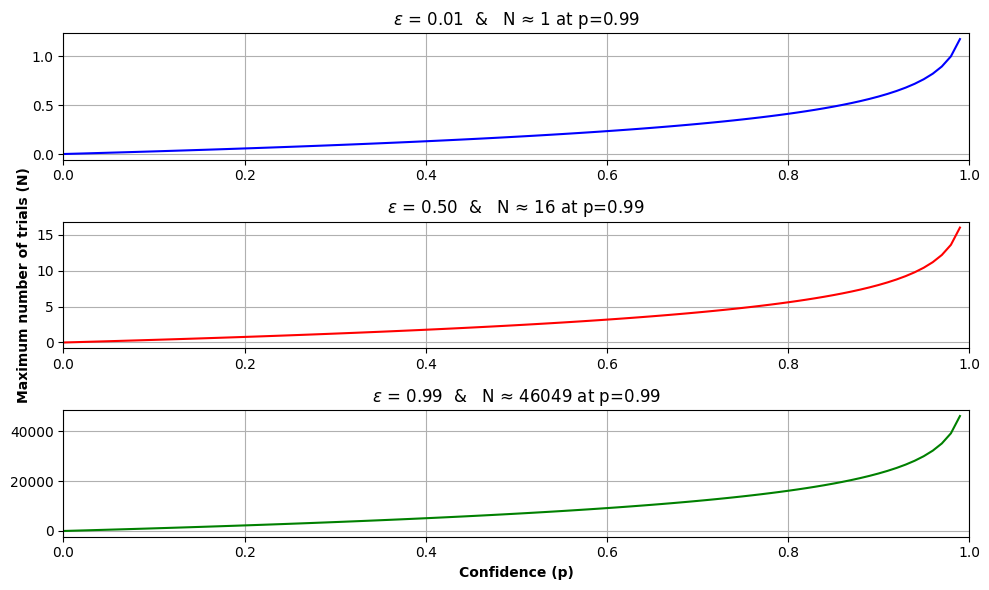

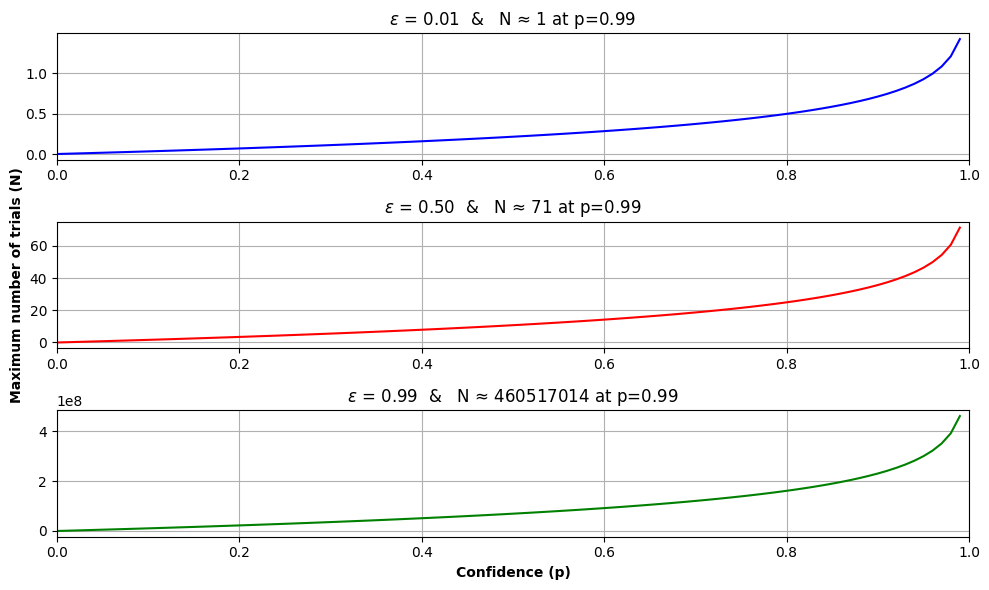

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# First block
p = np.arange(0, 1.0, 0.01)
err = [0.01, 0.5, 0.99]
n = 2

N = np.zeros((len(err), len(p)))
for ii in range(len(err)):
    N[ii, :] = np.log(1.0 - p) / np.log(1.0 - (1.0 - err[ii])**n)

plt.figure(1, figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(p, N[0, :], 'b', linewidth=1.5)
plt.title(r'$\epsilon$' + f' = {err[0]:.2f}' + f'  &   N ≈ {N[0, -1]:.0f}' + f' at p={p[-1]}')
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0,1)

plt.subplot(3, 1, 2)
plt.plot(p, N[1, :], 'r', linewidth=1.5)
plt.title(r'$\epsilon$' + f' = {err[1]:.2f}' + f'  &   N ≈ {N[1, -1]:.0f}' + f' at p={p[-1]}')
plt.grid(True)
plt.ylabel('Maximum number of trials (N)', fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0,1)

plt.subplot(3, 1, 3)
plt.plot(p, N[2, :], 'g', linewidth=1.5)
plt.title(r'$\epsilon$' + f' = {err[2]:.2f}' + f'  &   N ≈ {N[2, -1]:.0f}' + f' at p={p[-1]}')
plt.grid(True)
plt.xlabel('Confidence (p)', fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0,1)

plt.tight_layout()
plt.show()

# Second block
n = 4

N = np.zeros((len(err), len(p)))
for ii in range(len(err)):
    N[ii, :] = np.log(1 - p) / np.log(1 - (1 - err[ii])**n)

plt.figure(2, figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(p, N[0, :], 'b', linewidth=1.5)
plt.title(r'$\epsilon$' + f' = {err[0]:.2f}' + f'  &   N ≈ {N[0, -1]:.0f}' + f' at p={p[-1]}')
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0,1)

plt.subplot(3, 1, 2)
plt.plot(p, N[1, :], 'r', linewidth=1.5)
plt.title(r'$\epsilon$' + f' = {err[1]:.2f}' + f'  &   N ≈ {N[1, -1]:.0f}' + f' at p={p[-1]}')
plt.grid(True)
plt.ylabel('Maximum number of trials (N)', fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0,1)

plt.subplot(3, 1, 3)
plt.plot(p, N[2, :], 'g', linewidth=1.5)
plt.title(r'$\epsilon$' + f' = {err[2]:.2f}' + f'  &   N ≈ {N[2, -1]:.0f}' + f' at p={p[-1]}')
plt.grid(True)
plt.xlabel('Confidence (p)', fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0,1)

plt.tight_layout()
plt.show()


## RANSAC Demo

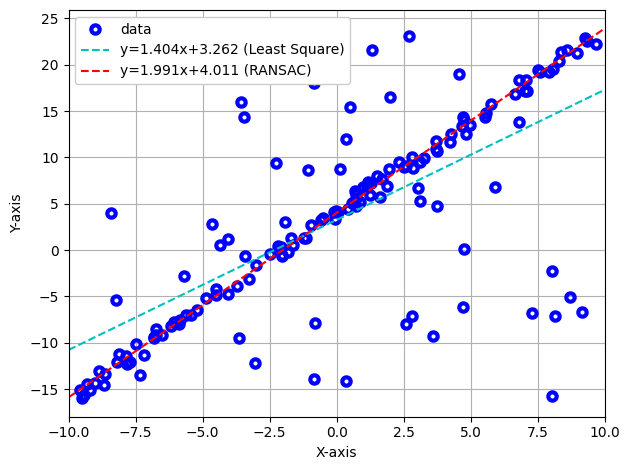

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def main():
    num_pt = 100

    # Line equation y = mx + b
    m = 2
    b = 4

    # x-axis range
    xrange = [-10, 10]
    x = np.random.rand(num_pt) * (xrange[1] - xrange[0]) + xrange[0]

    y_true = m * x + b
    y = y_true + (np.random.rand(num_pt) * 2 - 1)

    yrange = [m * xi + b for xi in xrange]

    # Add outlier (50%)
    x_out = np.random.rand(int(num_pt * 0.5)) * (xrange[1] - xrange[0]) + xrange[0]
    y_out = np.random.rand(int(num_pt * 0.5)) * (yrange[1] - yrange[0]) + yrange[0]

    x_meas = np.concatenate((x, x_out))
    y_meas = np.concatenate((y, y_out))

    Xmat = np.vstack((x_meas, np.ones_like(x_meas))).T
    Ymat = y_meas
    fparam = np.linalg.lstsq(Xmat, Ymat, rcond=None)[0]

    param_best = cm_ransac_line(x_meas, y_meas, 1, 1000)

    plt.figure(1)
    plt.plot(x_meas, y_meas, 'ob', fillstyle='none', markeredgewidth=3)
    plt.plot(xrange, [fparam[0] * xi + fparam[1] for xi in xrange], 'c--', linewidth=1.5)
    plt.plot(xrange, [param_best[0] * xi + param_best[1] for xi in xrange], 'r--', linewidth=1.5)

    legend_strings = ['data',
                      f'y={fparam[0]:.3f}x+{fparam[1]:.3f} (Least Square)',
                      f'y={param_best[0]:.3f}x+{param_best[1]:.3f} (RANSAC)']
    plt.legend(legend_strings, loc=2, fontsize=10, facecolor="white", framealpha=1)
    plt.grid(True)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim(xrange)
    plt.tight_layout()
    plt.show()

def cm_ransac_line(x_data, y_data, dist_thr, max_n_trials):
    nData = len(x_data)
    param_best = np.zeros(2)
    num_inliner_best = 0

    for ii in range(max_n_trials):
        pt_idx = np.random.choice(nData, 2, replace=False)
        x_sub = x_data[pt_idx]
        y_sub = y_data[pt_idx]

        mh = (np.diff(y_sub) / np.diff(x_sub))[0]
        bh = (np.linalg.det(np.vstack((y_sub, x_sub)).T) / np.diff(x_sub))[0]

        dist_pt = np.abs(mh * x_data + bh - y_data)
        num_inlier = np.sum(dist_pt < dist_thr)

        if num_inlier > num_inliner_best:
            param_best[0] = mh
            param_best[1] = bh
            num_inliner_best = num_inlier

    return param_best

if __name__ == "__main__":
    main()
